In [1]:
from datasets import load_dataset
import pandas as pd

In [7]:
#dataset1

# Load the dataset from Hugging Face Hub
train_dataset = load_dataset("kmack/Phishing_urls", split="train")
test_dataset = load_dataset("kmack/Phishing_urls", split="test")
valid_dataset = load_dataset("kmack/Phishing_urls", split="valid")

# Convert to pandas DataFrame
train_df = train_dataset.to_pandas()
test_df = test_dataset.to_pandas()
valid_df = valid_dataset.to_pandas()


all_df = [train_df, test_df,valid_df]
for i, df in enumerate(all_df):
    df['url'] = df['text']
    df.drop('text',axis=1,inplace=True)
print(train_df.head())

   label                                                url
0      0             xenophongroup.com/montjoie/compgns.htm
1      1    www.azzali.eu/&usg=AOvVaw2phVSb_ENMrkATGNx5LQ0l
2      1                     guildmusic.edu.au/js/index.htm
3      1  memo.unexpectedrunner.com/ezxgytw4et\nholotili...
4      0  en.wikipedia.org/wiki/Category:American_televi...


In [6]:
# Special tokens
special_tokens = ['<PAD>', '<UNK>', '<START>', '<END>']

# ASCII printable characters
ascii_chars = [chr(i) for i in range(32, 127)]  # ' ' (space) to '~'

# Full vocabulary
vocab = special_tokens + ascii_chars

# Create mappings
char2idx = {ch: idx for idx, ch in enumerate(vocab)}
idx2char = {idx: ch for ch, idx in char2idx.items()}

print("Vocabulary size:", len(vocab))
print("Sample:", vocab[:50])


Vocabulary size: 99
Sample: ['<PAD>', '<UNK>', '<START>', '<END>', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M']


In [35]:
from tqdm import tqdm
import numpy as np

tqdm.pandas()

max_url_length = 200


def encode_url(url):
    encoded = np.ones(max_url_length, dtype=int) * char2idx['<PAD>']  # padding value
    for i, ch in enumerate(url[:max_url_length]):
        encoded[i] = char2idx.get(ch, char2idx['<UNK>'])
    return encoded

# Apply encoding to your URL column
train_df['encode'] = train_df['url'].progress_apply(encode_url)
test_df['encode'] = test_df['url'].progress_apply(encode_url)
valid_df['encode'] = valid_df['url'].progress_apply(encode_url)



100%|██████████| 70882/70882 [00:00<00:00, 109390.59it/s]


In [36]:
vocab_size = len(vocab)
train_df['encode'] = train_df['encode'].progress_apply(lambda enc: enc / vocab_size)
test_df['encode'] = test_df['encode'].progress_apply(lambda enc: enc / vocab_size)
valid_df['encode'] = valid_df['encode'].progress_apply(lambda enc: enc / vocab_size)

100%|██████████| 70882/70882 [00:00<00:00, 385250.19it/s]


In [37]:
train_df.encode.head()

0    [0.9292929292929293, 0.7373737373737373, 0.828...
1    [0.9191919191919192, 0.9191919191919192, 0.919...
2    [0.7575757575757576, 0.898989898989899, 0.7777...
3    [0.8181818181818182, 0.7373737373737373, 0.818...
4    [0.7373737373737373, 0.8282828282828283, 0.181...
Name: encode, dtype: object

In [55]:
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert encoded URLs to proper tensors
url_tensor = torch.tensor(np.stack(train_df['encode'].values), dtype=torch.long)
labels_tensor = torch.tensor(train_df['label'].values, dtype=torch.long)

valid_url_tensor = torch.tensor(np.stack(valid_df['encode'].values), dtype=torch.long)
valid_labels_tensor = torch.tensor(valid_df['label'].values, dtype=torch.long)

test_url_tensor = torch.tensor(np.stack(test_df['encode'].values), dtype=torch.long)
test_labels_tensor = torch.tensor(test_df['label'].values, dtype=torch.long)


train_dataset = TensorDataset(url_tensor, labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)

val_dataset = TensorDataset(valid_url_tensor, valid_labels_tensor)
val_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False)

test_dataset = TensorDataset(test_url_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)


In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class URLBinaryCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=32, num_classes=1, max_len=200):
        super(URLBinaryCNN, self).__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=char2idx['<PAD>']
        )
        # Convolution layers
        self.conv1 = nn.Conv1d(in_channels=embed_dim, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.AvgPool1d(kernel_size=2)
        
        # Fully connected layer
        self.fc = nn.Linear(64 * (max_len // 2), num_classes)  # after one pooling
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # x: [batch_size, seq_len]
        x = self.embedding(x)           # [batch, seq_len, embed_dim]
        x = x.permute(0, 2, 1)         # [batch, embed_dim, seq_len] for conv1d
        x = F.relu(self.conv1(x))      
        x = F.relu(self.conv2(x))
        x = self.pool(x)               # downsample by 2
        x = x.view(x.size(0), -1)      # flatten
        x = self.fc(x)
        x = self.sigmoid(x)            # output probability
        return x


In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = URLBinaryCNN(vocab_size=len(vocab), embed_dim=32).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_x.size(0)
        preds = (outputs >= 0.5).float()
        correct_train += (preds == batch_y).sum().item()
        total_train += batch_x.size(0)
    
    train_acc = correct_train / total_train
    
    # Validation
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device).float().unsqueeze(1)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_x.size(0)
            preds = (outputs >= 0.5).float()
            correct_val += (preds == batch_y).sum().item()
            total_val += batch_x.size(0)
    
    val_acc = correct_val / total_val
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss/total_train:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss/total_val:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/5 | Train Loss: 0.6932, Train Acc: 0.4998 | Val Loss: 0.6932, Val Acc: 0.4988
Epoch 2/5 | Train Loss: 0.6932, Train Acc: 0.5000 | Val Loss: 0.6932, Val Acc: 0.4988
Epoch 3/5 | Train Loss: 0.6931, Train Acc: 0.4998 | Val Loss: 0.6932, Val Acc: 0.4988
Epoch 4/5 | Train Loss: 0.6931, Train Acc: 0.5004 | Val Loss: 0.6932, Val Acc: 0.4988
Epoch 5/5 | Train Loss: 0.6932, Train Acc: 0.5001 | Val Loss: 0.6931, Val Acc: 0.5012


In [57]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch


In [58]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for i in range(0, len(test_url_tensor), 64):  # batch size 64
        batch_x = test_url_tensor[i:i+64].to(device)
        batch_y = test_labels_tensor[i:i+64].to(device)
        
        outputs = model(batch_x)
        preds = (outputs >= 0.5).long().squeeze(1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())


Confusion Matrix:
 [[    0 35239]
 [    0 35643]]


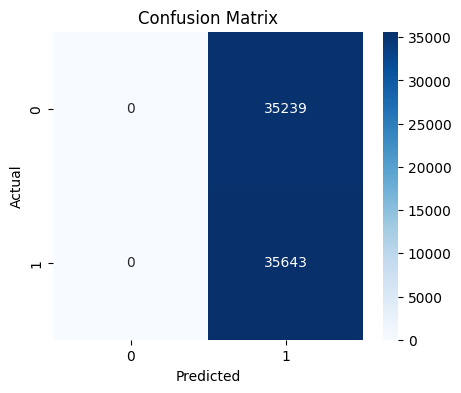

              precision    recall  f1-score   support

        Safe       0.00      0.00      0.00     35239
    Phishing       0.50      1.00      0.67     35643

    accuracy                           0.50     70882
   macro avg       0.25      0.50      0.33     70882
weighted avg       0.25      0.50      0.34     70882



c:\Users\rrpra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rrpra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rrpra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [59]:
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Optional: pretty plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(all_labels, all_preds, target_names=['Safe', 'Phishing']))


### 🧮 Accuracy for char based models (CNN)

> **Accuracy:** `0.50`

| Class | Precision | Recall | F1-Score | Support |
|:------|:-----------|:--------|:----------|:----------|
| **0** | 0.00 | 0.00 | 0.00 | 35239 |
| **1** | 0.50 | 1.00 | 0.67 | 35643 |
| **Accuracy** |  |  | **0.50** | 70882 |
| **Macro Avg** | 0.25 | 0.50 | 0.33 | 70882 |
| **Weighted Avg** | 0.25 | 0.50 | 0.34 | 70882 |